In [195]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.utils import to_categorical

import seaborn as sns

from sklearn.preprocessing import StandardScaler

from keras.models import Sequential


from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import warnings
warnings.simplefilter("ignore")


In [196]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    
    # Iterate through each folder in the main directory
    for subdir in tqdm(os.listdir(DIR)):
        subdir_path = os.path.join(DIR, subdir)
        
        # Check if it's a directory before processing
        if os.path.isdir(subdir_path):
            # Now iterate over images in each subdirectory
            for IMAGE_NAME in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, IMAGE_NAME)
                _, ftype = os.path.splitext(img_path)
                
                # Check if the file is a jpg image
                if ftype.lower() == ".jpg":
                    img = read(img_path)
                    img = cv2.resize(img, (RESIZE, RESIZE))          
                    IMG.append(np.array(img))
                    
    return IMG

# Load images
benign_train = np.array(Dataset_loader('/kaggle/input/breast-cancer-deep-learning/breast cancer/Train/Benign', 224))
malign_train = np.array(Dataset_loader('/kaggle/input/breast-cancer-deep-learning/breast cancer/Train/Malignant', 224))
benign_test = np.array(Dataset_loader('/kaggle/input/breast-cancer-deep-learning/breast cancer/Test/Benign', 224))
malign_test = np.array(Dataset_loader('/kaggle/input/breast-cancer-deep-learning/breast cancer/Test/Malignant', 224))

100%|██████████| 8/8 [00:00<00:00, 130.21it/s]


# **-- Data Preprocessing Part --**

In [201]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
x_train = np.concatenate((benign_train, malign_train), axis = 0)
y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
x_test = np.concatenate((benign_test, malign_test), axis = 0)
y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)


# Shuffle train data
s = np.arange(x_train.shape[0])
np.random.shuffle(s)
x_train = x_train[s]
y_train = y_train[s]


# Shuffle test data
s = np.arange(x_test.shape[0])
np.random.shuffle(s)
x_test = x_test[s]
y_test = y_test[s]

In [202]:
# To categorical
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [203]:
# split dataset into train and validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, 
    test_size=0.2, 
    random_state=11
)

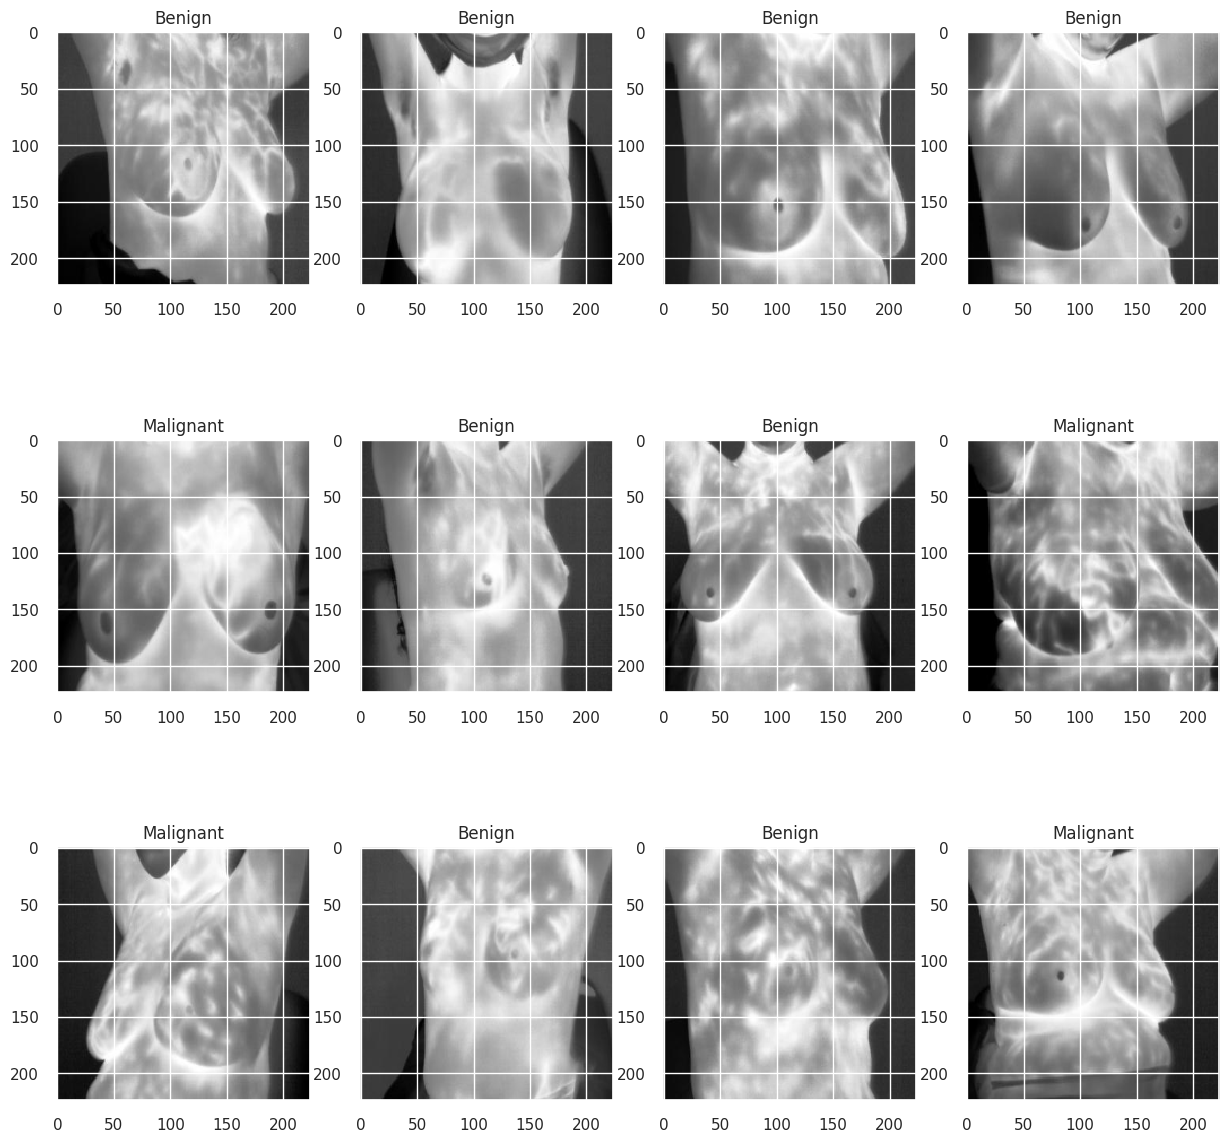

In [204]:
# visualization image
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [205]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to the data
datagen.fit(x_train)


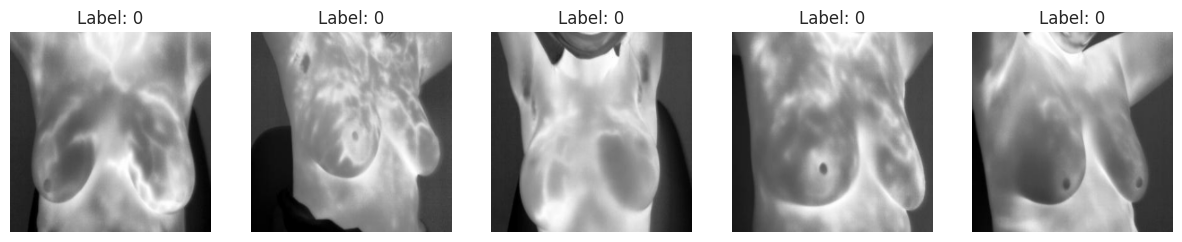

In [206]:
def plot_samples(images, labels, n=5):
    plt.figure(figsize=(15,5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

plot_samples(x_train, y_train.argmax(axis=1))


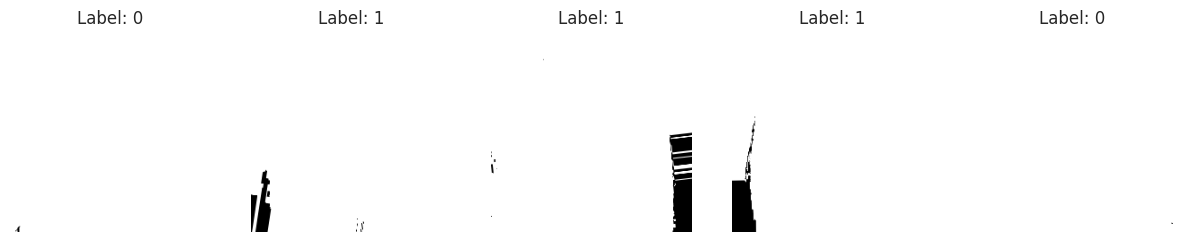

In [207]:
augmented_images, augmented_labels = next(datagen.flow(x_train, y_train, batch_size=5))
plot_samples(augmented_images, augmented_labels.argmax(axis=1))


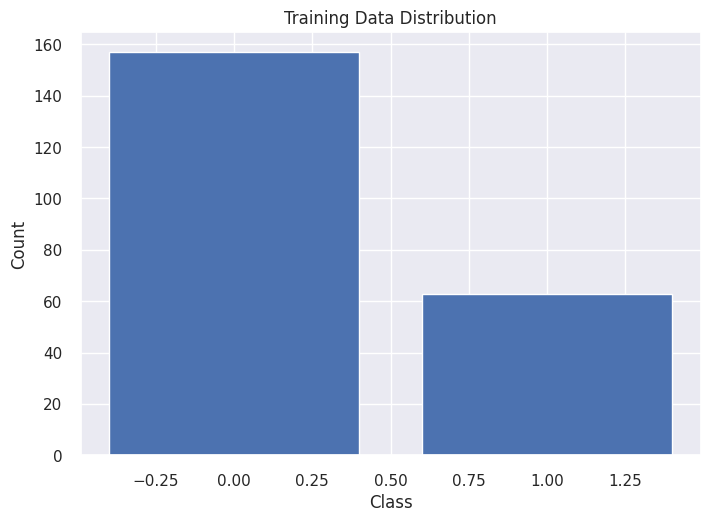

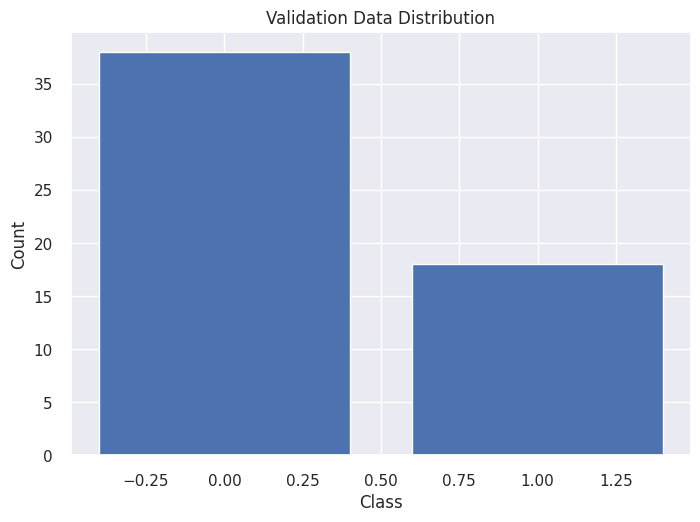

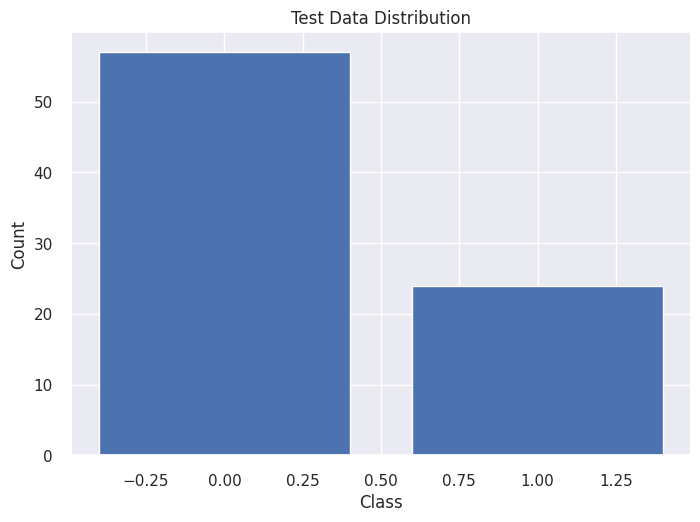

In [208]:
# Data Distribution Visualization

def plot_distribution(y, title):
    labels, counts = np.unique(y.argmax(axis=1), return_counts=True)
    plt.bar(labels, counts)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

plot_distribution(y_train, "Training Data Distribution")
plot_distribution(y_val, "Validation Data Distribution")
plot_distribution(y_test, "Test Data Distribution")


# For Diagnostic Chart 

In [180]:
# Load diagnostic chart

file_path = '/kaggle/input/breast-cancer-deep-learning/breast cancer/Diagnostics.xlsx'

In [182]:
df = pd.read_excel(file_path)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print("Data Sample:")
print(df.head())

Data Sample:
     Image Left Right  Weight (Kg)  Height(cm)  Temp(°C)  Age(years)
0  IIR0001   PB     N         45.6       156.0      36.2          19
1  IIR0002    N    PB         61.6       160.6      36.6          33
2  IIR0003    N    PB         46.2       172.5      36.0          18
3  IIR0004   PB     N         82.3       163.9      35.6          26
4  IIR0005   PB     N         59.6       163.0      36.5          26


In [184]:
# 1. Data Accessing and Preprocessing

def load_and_preprocess_data(file_path):
    """
    Load and preprocess the XLX file
    """
    
    df = pd.read_excel(file_path)
    
    print("Missing values:\n", df.isnull().sum())
    
    # Remove duplicates
    df = df.drop_duplicates()
    
    # Check for and handle outliers using IQR method
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    return df
df


,Image,Left,Right,Weight (Kg),Height(cm),Temp(°C),Age(years)
0,IIR0001,PB,N,45.6,156.0,36.2,19
1,IIR0002,N,PB,61.6,160.6,36.6,33
2,IIR0003,N,PB,46.2,172.5,36.0,18
3,IIR0004,PB,N,82.3,163.9,35.6,26
4,IIR0005,PB,N,59.6,163.0,36.5,26
...,...,...,...,...,...,...,...
114,IIR0115,N,PB,65.7,172.0,35.4,45
115,IIR0116,N,PB,68.4,155.5,36.2,43
116,IIR0117,PB,N,70.0,163.0,36.0,37
117,IIR0118,PB,N,76.5,158.5,36.1,38


In [187]:
# Prepare features and target
X = df[['Left', 'Right', 'Height(cm)', 'Age(years)']]
y = df['Weight (Kg)']

# Split the dataset into training and test sets
test_size = 0.2
val_size = 0.2

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Second split: create validation set from remaining data
val_size_adjusted = val_size / (1 - test_size)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size_adjusted, random_state=42)

# Print the splits
print("X_train:\n", X_train.head())
print("X_val:\n", X_val.head())
print("X_test:\n", X_test.head())
print("y_train:\n", y_train.head())
print("y_val:\n", y_val.head())
print("y_test:\n", y_test.head())

X_train:
     Left Right  Height(cm)  Age(years)
113    N    PB       161.0          45
30     N    PB       160.0          57
17    PB     N       159.0          67
101   PM     N       154.2          46
7      N    PB       168.0          24
X_val:
     Left Right  Height(cm)  Age(years)
59     N    PB       164.5          39
77     N    PB       151.0          50
29     N    PM       161.0          53
105   PB     N       167.0          41
44    PB     N       163.0          40
X_test:
    Left Right  Height(cm)  Age(years)
56   PB     N       161.5          44
89   PB    PB       159.0          48
4    PB     N       163.0          26
45    N    PM       157.6          74
26    N    PB       147.0          48
y_train:
 113    76.4
30     60.0
17     81.1
101    73.0
7      66.0
Name: Weight (Kg), dtype: float64
y_val:
 59      64.8
77      66.6
29     124.7
105     93.2
44      69.5
Name: Weight (Kg), dtype: float64
y_test:
 56    87.7
89    69.0
4     59.6
45    74.1
26    54.9
Na

In [189]:
# 3. Data Loading and Augmentation

from sklearn.preprocessing import StandardScaler, LabelEncoder

# Convert categorical columns to numerical codes
# assumes 'left' and 'right' contain categorical values

encoder = LabelEncoder()
X_train['Left'] = encoder.fit_transform(X_train['Left'])
X_train['Right'] = encoder.transform(X_train['Right'])
X_val['Left'] = encoder.transform(X_val['Left'])
X_val['Right'] = encoder.transform(X_val['Right'])
X_test['Left'] = encoder.transform(X_test['Left'])
X_test['Right'] = encoder.transform(X_test['Right'])

# Initialize the scaler
scaler = StandardScaler()

# Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrames to retain column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Display scaled data
print("X_train_scaled:\n", X_train_scaled.head())
print("X_val_scaled:\n", X_val_scaled.head())
print("X_test_scaled:\n", X_test_scaled.head())


X_train_scaled:
        Left     Right  Height(cm)  Age(years)
0 -0.962099  0.562027    0.589886   -0.270763
1 -0.962099  0.562027    0.449390    0.583645
2  0.522880 -0.863113    0.308894    1.295651
3  2.007859 -0.863113   -0.365488   -0.199562
4 -0.962099  0.562027    1.573359   -1.765976
X_val_scaled:
        Left     Right  Height(cm)  Age(years)
0 -0.962099  0.562027    1.081622   -0.697967
1 -0.962099  0.562027   -0.815076    0.085240
2 -0.962099  1.987167    0.589886    0.298842
3  0.522880 -0.863113    1.432863   -0.555566
4  0.522880 -0.863113    0.870878   -0.626766
X_test_scaled:
        Left     Right  Height(cm)  Age(years)
0  0.522880 -0.863113    0.660134   -0.341964
1  0.522880  0.562027    0.308894   -0.057161
2  0.522880 -0.863113    0.870878   -1.623575
3 -0.962099  1.987167    0.112199    1.794056
4 -0.962099  0.562027   -1.377060   -0.057161


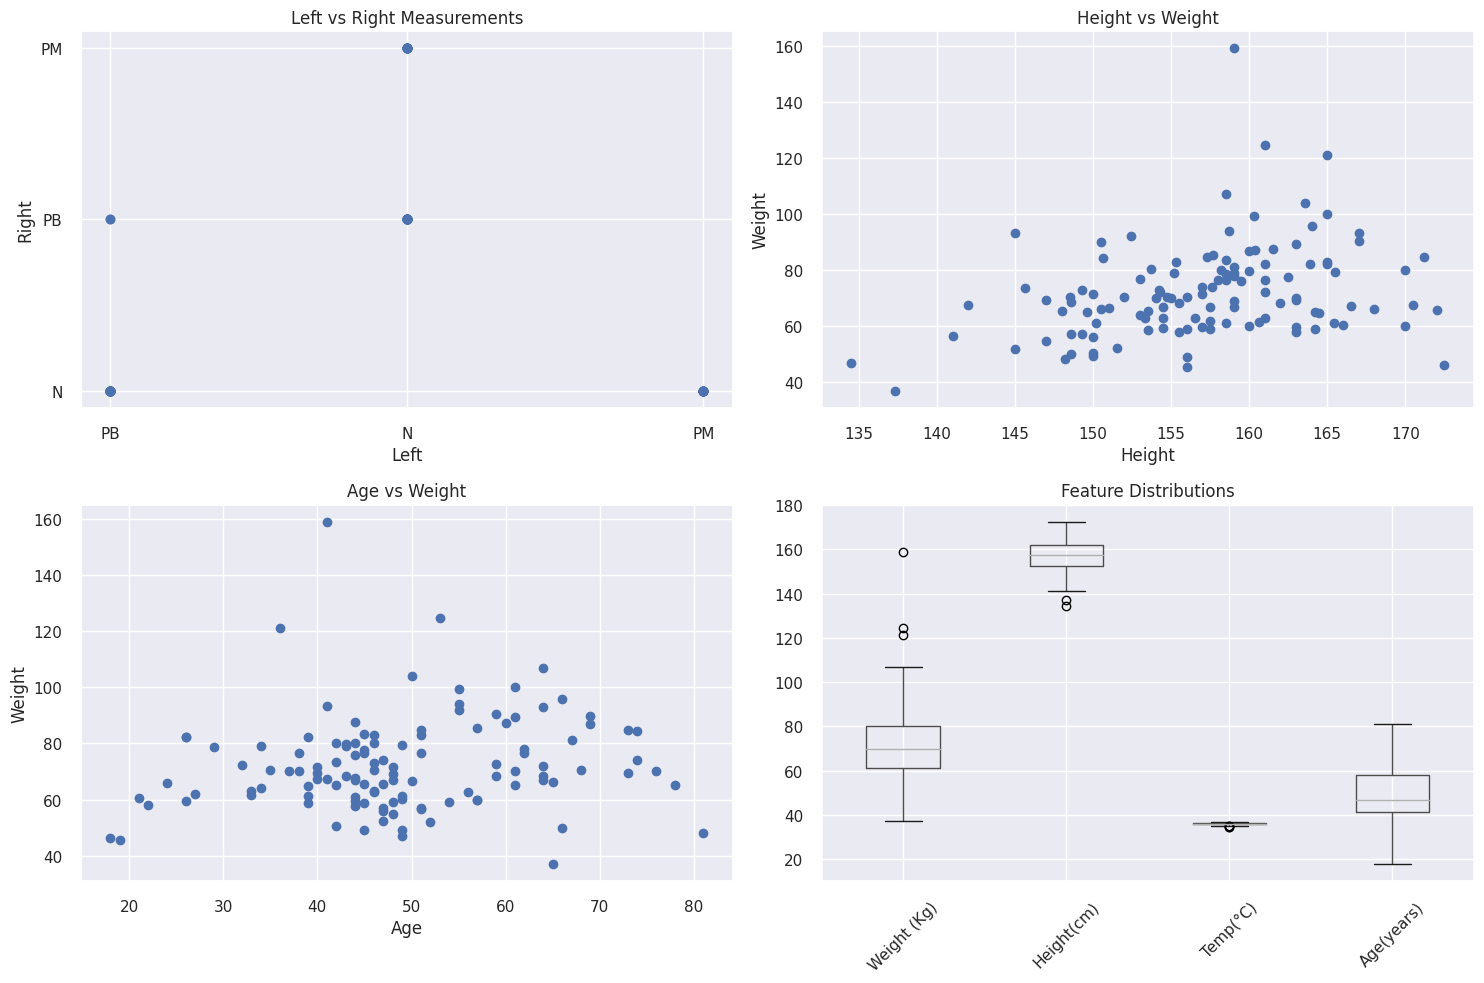

In [194]:
# 4. Sample Data Visualization


# Set up the figure for multiple subplots
plt.figure(figsize=(15, 10))

# Scatter plot: Left vs Right
plt.subplot(2, 2, 1)
plt.scatter(df['Left'], df['Right'])
plt.xlabel('Left')
plt.ylabel('Right')
plt.title('Left vs Right Measurements')

# Height vs Weight
plt.subplot(2, 2, 2)
plt.scatter(df['Height(cm)'], df['Weight (Kg)'])
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height vs Weight')

# Age vs Weight
plt.subplot(2, 2, 3)
plt.scatter(df['Age(years)'], df['Weight (Kg)'])
plt.xlabel('Age')
plt.ylabel('Weight')
plt.title('Age vs Weight')

# Box plot of all features
plt.subplot(2, 2, 4)
df.boxplot()
plt.xticks(rotation=45)
plt.title('Feature Distributions')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


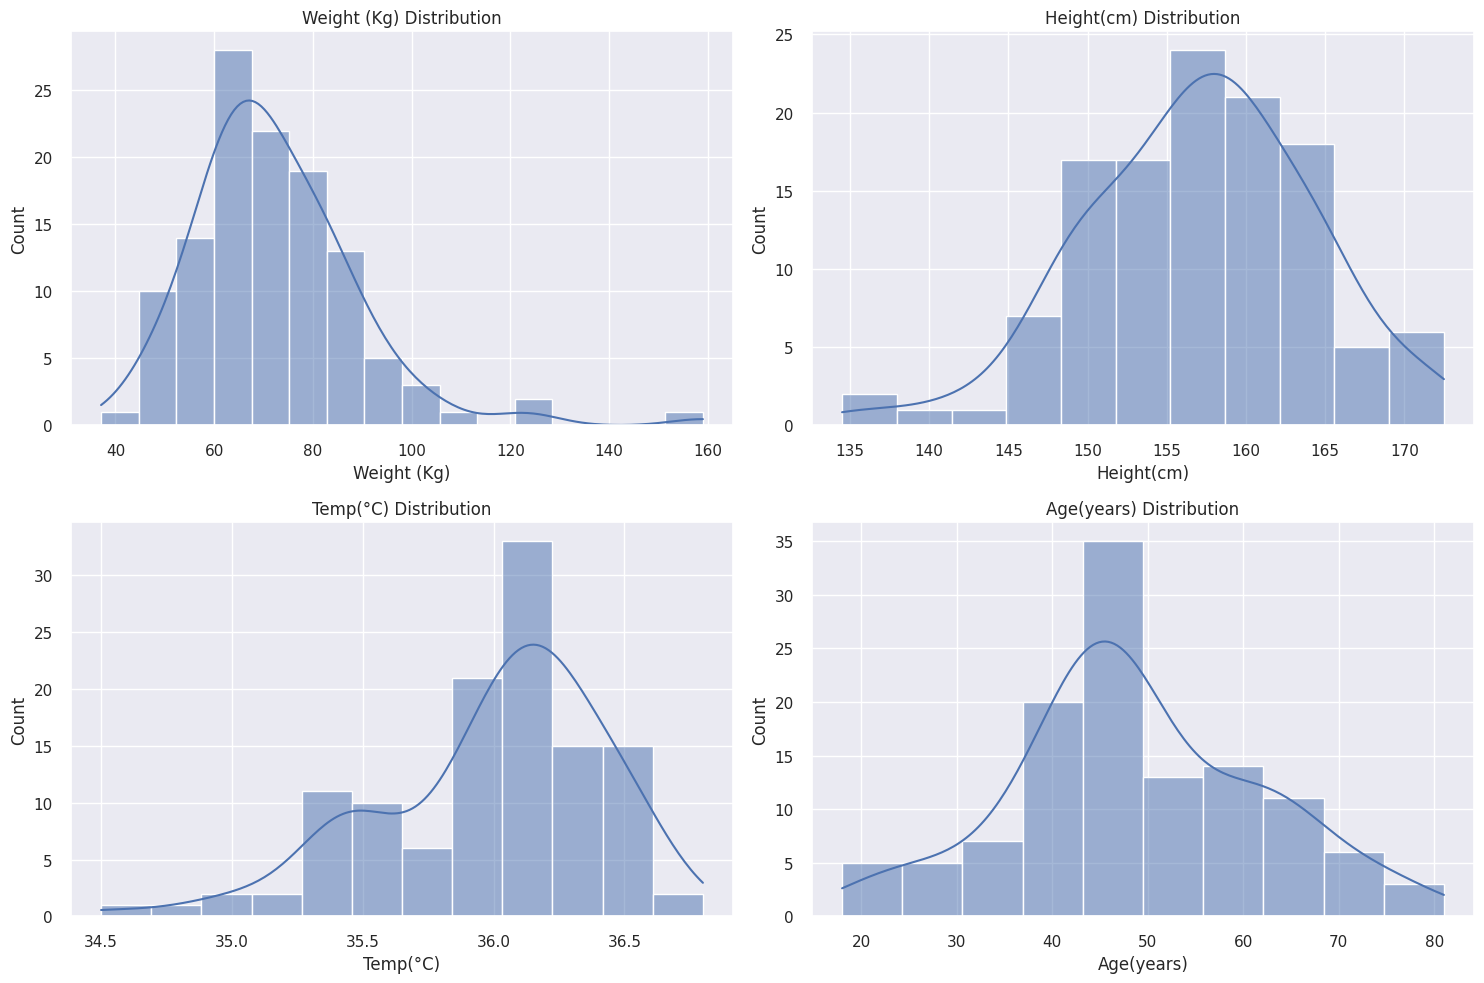

In [193]:
# 5. Data Distribution Visualization


import math

# Select only numeric columns from the DataFrame
df_numeric = df.select_dtypes(include=['number'])

# Calculate the number of rows needed for subplots (2 columns per row)
num_columns = len(df_numeric.columns)
num_rows = math.ceil(num_columns / 2)

# Set up figure for feature distribution plots
plt.figure(figsize=(15, 5 * num_rows))

# Create histograms for each numeric column in the DataFrame
for i, column in enumerate(df_numeric.columns, 1):
    plt.subplot(num_rows, 2, i)
    sns.histplot(df_numeric[column], kde=True)
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Count')

# Adjust layout and display distribution plots
plt.tight_layout()
plt.show()




In [157]:
# Adjusted function to match dataset columns
def create_patient_sentences(dataframe):
    sentences = []
    for _, row in dataframe.iterrows():
        # Using exact column names as in the dataset sample
        sentence = f"The patient is a {row['Age(years)']}-year-old with a weight of {row['Weight (Kg)']} kg, height of {row['Height(cm)']} cm, and body temperature of {row['Temp(°C)']}°C."
        sentences.append(sentence)
    return sentences

# Generate patient sentences with the updated column names

patient_sentences = create_patient_sentences(chart_data)

# Display some patient sentences
for sentence in patient_sentences[:5]:
    print(sentence)


The patient is a 19-year-old with a weight of 45.6 kg, height of 156.0 cm, and body temperature of 36.2°C.
The patient is a 33-year-old with a weight of 61.6 kg, height of 160.6 cm, and body temperature of 36.6°C.
The patient is a 18-year-old with a weight of 46.2 kg, height of 172.5 cm, and body temperature of 36.0°C.
The patient is a 26-year-old with a weight of 82.3 kg, height of 163.9 cm, and body temperature of 35.6°C.
The patient is a 26-year-old with a weight of 59.6 kg, height of 163.0 cm, and body temperature of 36.5°C.
